In [1]:
import pandas as pd

df = pd.read_csv('../../Output/output_little.csv')
# df = pd.concat([
#     pd.read_csv(F'../../Output/output_{i}.csv').drop(columns=[x for x in df.columns if 'id' in x]) 
#     for i in range(1, 12)])

for i in range(1,56):
    df = df.drop(f"{i}-neighbour id", axis='columns')
    
df = df.drop("id", axis='columns')
df = df.drop("nb", axis='columns')
df = df.drop("1-faced", axis='columns')
df = df.drop("2-faced", axis='columns')
df = df.drop("7-faced", axis='columns')
df = df.drop("8-faced", axis='columns')
df = df.drop("9-faced", axis='columns')
df = df.drop("10-faced", axis='columns')
df = df.drop("11-faced", axis='columns')
df = df.drop("12-faced", axis='columns')
df = df.drop("13-faced", axis='columns')

df.head()

,x,y,z,type,1-neighbour type,1-neighbour x,1-neighbour y,1-neighbour z,2-neighbour type,2-neighbour x,...,54-neighbour y,54-neighbour z,55-neighbour type,55-neighbour x,55-neighbour y,55-neighbour z,3-faced,4-faced,5-faced,6-faced
0,43.07270,-0.460897,-3.45209,1.28,1.28,38.59530,-3.40266,-3.45435,1.60,48.71700,...,54.187100,-3.51869,1.28,1.38847,49.76220,-3.52047,0.0,3.0,2.0,3.0
1,5.27795,17.340300,-3.60043,1.28,1.60,6.26153,19.75670,-3.68185,1.60,2.44928,...,-0.991247,-3.59534,1.60,54.43220,48.14350,-3.48367,0.0,0.0,3.0,6.0
2,43.06580,30.450600,-3.55847,1.28,1.60,41.76430,27.83750,-3.52070,1.60,41.01610,...,5.643890,-3.60515,1.28,-1.75044,3.83267,-3.48604,0.0,2.0,2.0,5.0
3,53.55130,34.234100,-3.60678,1.28,1.60,51.02080,26.76780,-3.68310,1.28,43.69170,...,5.643890,-3.60515,1.28,-1.75044,3.83267,-3.48604,0.0,1.0,3.0,4.0
4,2.44928,17.796900,-3.48764,1.60,1.28,5.27795,17.34030,-3.60043,1.60,6.26153,...,-0.991247,-3.59534,1.60,54.43220,48.14350,-3.48367,0.0,1.0,3.0,5.0


In [2]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

In [3]:
data = df.to_numpy()
data = data.astype(np.float32)

inp_data_train, inp_data_test, out_data_train, out_data_test = train_test_split(
    data[:, :-4], data[:, -4:], test_size=0.2, random_state=123)

inp_data_test, inp_data_valid, out_data_test, out_data_valid = train_test_split(
    inp_data_test, out_data_test, test_size=0.5, random_state=123)

inp_data_test , out_data_test  = \
    torch.from_numpy(inp_data_test) , torch.from_numpy(out_data_test)

inp_data_train, out_data_train = \
    torch.from_numpy(inp_data_train), torch.from_numpy(out_data_train)

inp_data_valid, out_data_valid = \
    torch.from_numpy(inp_data_valid), torch.from_numpy(out_data_valid)

In [43]:
train_dataset = TensorDataset(inp_data_train, out_data_train)
valid_dataset = TensorDataset(inp_data_valid, out_data_valid)
test_dataset  = TensorDataset(inp_data_test , out_data_test )

In [44]:
BATCH_SIZE = 4 # todo: more stable updating model parameters.

In [45]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE)
test_loader  = torch.utils.data.DataLoader(test_dataset , batch_size=BATCH_SIZE)

In [46]:
import torch.nn as nn
import torch.nn.functional as nf

class RegressionMultiout(nn.Module):
    def __init__(self, inputs_size, output_size):
        super(RegressionMultiout, self).__init__()
        
        self.vorono = nn.Sequential(
            nn.Linear(inputs_size, 8),
            nn.Dropout(0.5),
            nn.BatchNorm1d(8),
            nn.LeakyReLU(),
            nn.Linear(8, output_size),
        )
        
        self.init_weights()
        
    def init_weights(self):
        
        def inner_init_weights(layer):
            if not isinstance(layer, nn.Linear):
                return
            
            nn.init.xavier_uniform_(layer.weight.data)
            nn.init.constant_(layer.bias.data, 0.1)
            
        self.vorono.apply(inner_init_weights)

        
    def forward(self, x):
        return self.vorono(x)

In [47]:
INPUT_SIZE, OUTPUT_SIZE = inp_data_train.shape[1], out_data_train.shape[1]

In [48]:
model = RegressionMultiout(INPUT_SIZE, OUTPUT_SIZE)
model

RegressionMultiout(
  (vorono): Sequential(
    (0): Linear(in_features=224, out_features=8, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [49]:
from torch.optim import AdamW, Adam
from torch.optim.lr_scheduler import StepLR

num_epochs = 200
batch_size_train = len(train_loader)
batch_size_valid = len(valid_loader)

criterion = torch.nn.MSELoss()
optimizer = Adam(model.parameters(), lr=5e-3)
scheduler = StepLR(optimizer, step_size=10, gamma=0.9) 

005.running_loss: 4.20650
010.running_loss: 2.61974
015.running_loss: 1.96227
020.running_loss: 1.72355
025.running_loss: 1.52881
030.running_loss: 1.45253
035.running_loss: 1.20885
040.running_loss: 1.22189
045.running_loss: 1.34433
050.running_loss: 1.13471
055.running_loss: 1.39357
060.running_loss: 1.36683
065.running_loss: 1.34421
070.running_loss: 1.02884
075.running_loss: 1.28476
080.running_loss: 1.06267
085.running_loss: 1.13588
090.running_loss: 1.08842
095.running_loss: 1.38188
100.running_loss: 0.99281
105.running_loss: 1.12714
110.running_loss: 1.15896
115.running_loss: 1.10345
120.running_loss: 1.12537
125.running_loss: 1.06096
130.running_loss: 1.06651
135.running_loss: 0.96228
140.running_loss: 0.95051
145.running_loss: 0.87701
150.running_loss: 0.92038
155.running_loss: 0.77191
160.running_loss: 0.95530
165.running_loss: 1.03801
170.running_loss: 0.86897
175.running_loss: 0.94582
180.running_loss: 0.75243
185.running_loss: 0.93393
190.running_loss: 0.82640
195.running_

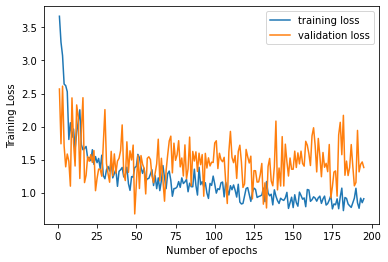

In [50]:
import matplotlib.pyplot as plt

train_loss = []
validation_loss = []

for epoch in range(1, num_epochs + 1):
    
    running_loss = 0
    
    for inp_train, out_train in train_loader:
        
        prediction = model(inp_train)
        loss = criterion(prediction, out_train)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    with torch.no_grad():
        
        test_loss = 0
        for inp_valid, out_valid in valid_loader:
        
            prediction = model(inp_valid)
            loss = criterion(prediction, out_valid)
            test_loss += loss.item()
        
    scheduler.step()
    
    running_loss /= batch_size_train
    train_loss.append(running_loss)
        
    test_loss /= batch_size_valid
    validation_loss.append(test_loss)
    
    
    if epoch % 5 == 0:
#         print('%03d.learning_rate: %.05f' % (epoch, optimizer.param_groups[0]["lr"]))
        print('%03d.running_loss: %.05f' % (epoch, running_loss))
    
plt.plot(range(1, num_epochs - 4), train_loss[5:], label='training loss')
plt.plot(range(1, num_epochs - 4), validation_loss[5:], label='validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.show()

In [14]:
test_predictions = model(inp_data_test)

In [68]:
idx = np.random.randint(0, test_predictions.shape[0])
print('Test-Prediction :', np.round(test_predictions[idx].detach().numpy(), 0))
print('Real output:', out_data_test[idx].detach().numpy())

Test-Prediction : [-0.  2.  3.  2.]
Real output: [0. 0. 3. 6.]


In [69]:
train_predictions = model(inp_data_train)

In [75]:
idx = np.random.randint(0, train_predictions.shape[0])
print('Prediction :', np.round(train_predictions[idx].detach().numpy(), 0))
print('Real output:', out_data_train[idx].detach().numpy())

Prediction : [-0.  0.  2.  8.]
Real output: [0. 0. 2. 8.]
